# DAE for Plasma Dignostic

Plasma accelerator is one of the important tools in science, plasma acceleration has made great progress and promises a cheaper in a smaller scale acceleration.  Considering the fact that plasma wake-field acceleration is working based on the plasma wave oscillation, having a clear knowledge of plasma frequency is a crucial part of the PWFA to avoid decelerating. Fortunately, due to the dependency of plasma frequency on the plasma density, by investigation on plasma density using the stark broadening, a clear knowledge of plasma frequency would be achievable. 

However, measuring the plasma density by spectrometer is not always easy, sometimes due to the bad alignment of mirrors and lenses, or due to the low applied voltage on the plasma, the result is noisy, and measuring the denisty is challenging. 



In this project, we want to use the Neural network, to denoise the low voltage results by learning from the result of high voltage which usually are more clean and visible.

-- in the first case, we use the same voltage but with different time response delay:


-- then we use higher voltage with feeding the model with more samples.

In [2]:
# Importing all the important libraries

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import skimage
import os
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split

import random
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
import torchsummary

# The Neural Network architecture

Here, we create our model, we have Encoder, and Decoder


# Encoder

In [3]:
# defining our encoder layers

class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
        nn.Linear(32*31*127, 128),
        nn.ReLU(True),
        nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x


# Decoder 

In [4]:
# defining our decoder layers

class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 32*31*127),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32,31,127))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

# Training 


In [5]:
encoded_space_dim=1
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!) by using per-parameters option
lr = 1e-2
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(' The device is **{}**'.format (device))



# Move both the encoder and the decoder to the selected device
print(encoder.to(device))
print(decoder.to(device))
print(torchsummary.summary(encoder.to(device),(1,256,1024)))


 The device is **cuda**
Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=125984, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)
Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=125984, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 31, 127))
  (decoder_conv): Sequential(
    

# Training Function 

In [6]:
### Training function
def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer,noise_fac):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    
    for img in dataloader:
        # Move tensor to the proper device
        image_noisy =noise_maker(img,noise_fac).to(device)
        main_image = img.to(device)  
        # Encode data
        encoded_data = encoder(image_noisy)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, main_image)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('Partial Train loss is {}'.format(loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

# Validation function

In [7]:
### Testing function
def vali_epoch_den(encoder, decoder, device, dataloader, loss_fn,noise_fac):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for img in dataloader:
            # Move tensor to the proper device
            image = noise_maker(img,noise_fac).to(device)
            # Encode data
            encoded_data = encoder(image)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(img.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
        print('partial validation loss is {} '.format(val_loss.data))
    return val_loss.data

# Noise Function

In [8]:
# define our noise function
def noise_maker(inputs,noise_factor): 
    noisy=inputs+torch.randn_like(inputs)*noise_factor
    noisy=torch.clamp(noisy,0.,1)
    return noisy


# Initial Data Function

In [9]:
def compare(clean,train_dataset,noise,noise_factor,rand):
    
    noisy_sam=noise_maker(train_dataset,noise_factor)
    noisy_sam=noisy_sam.cpu().permute(0,2,3,1).squeeze().numpy()
    for i in range(1):
        plt.subplot(1,3,1)
        plt.imshow(clean[rand+i])
        plt.title('Clean data of sample {}'.format(rand+i))
        plt.subplot(1,3,2)
        plt.imshow(noisy_sam[rand+i])
        plt.title('gaussian noise on clean data of sample {}'.format(rand+i))
        plt.subplot(1,3,3)
        plt.imshow(noise[rand+i])
        plt.title('noisy data of sample {}'.format(rand+i))
        plt.subplots_adjust(left=1,
                    bottom=0.1, 
                    right=3, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.2) 
        plt.show()
    
    
    
    
    
    x=np.linspace(0,1024,1024)
    for i in range(1):
        plt.subplot(1,3,1)
        plt.plot(x,clean[rand+i][150])
        plt.title('Clean spectrum of sample {}'.format(rand+i))
        plt.subplot(1,3,2)
        plt.plot(x,noisy_sam[rand+i][150])
        plt.title('added noise to clean spectrum of sample {}'.format(rand+i))
        plt.subplot(1,3,3)
        plt.plot(x,noise[rand+i][100])
        plt.title('noisy spectrum of sample {}'.format(rand+i))
        plt.subplots_adjust(left=1,
                    bottom=0.1, 
                    right=3, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.2) 
        plt.show()
    

# Initial Results Function

In [10]:
#First function is for plotting the denoised images

def plotting(test_data,encoder,decoder,rand):
    n=1
    for i in range(n):
        
        img = test_data.to(device)
        encoder.eval()
        decoder.eval()
        
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
          
        
        original=img.cpu().permute(0,2,3,1).squeeze().numpy()
        #original=np.resize(original,(len(original),255,1024))    
        
        denoised=rec_img.cpu().permute(0,2,3,1).squeeze().numpy()
        #denoised=np.resize(denoised,(len(denoised),255,1024))  
        
        plt.subplot(1,2,1)
        plt.imshow(original[rand+i],cmap='binary')
        plt.title('original noisy image {}'.format(rand+i))
        plt.subplot(1,2,2)
        plt.imshow(denoised[rand+i],cmap='binary')
        plt.title('denoised image  {}'.format(rand+i))
        plt.subplots_adjust(left=1,
                    bottom=0.1, 
                    right=3, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.2) 
        
        plt.show()
        
    x=np.linspace(0,1024,1024)
    for i in range(n):
        plt.subplot(1,2,1)
        plt.plot(x,original[rand+i][100])
        plt.title('Clean spectrum of sample {}'.format(rand+i))
        plt.subplot(1,2,2)
        plt.plot(x,denoised[rand+i][100])
        plt.title('added noise to clean spectrum of sample {}'.format(rand+i))
        plt.subplots_adjust(left=1,
                    bottom=0.1, 
                    right=3, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.2) 
        plt.show()
   
    return(denoised)

# Final Analysis Function

In [11]:
def main(final):

    Mnd, MCv, MAv, MWv, MPv, MDv, MDl= [],[],[],[],[],[],[]
    for dim in range(len(final)):

        data=final[dim]
        N=len(data)
        lda=np.zeros(N) #array for density value at each transverse section / longitudinal dimenion
        tda=np.zeros(1024) # transverse section dimension

        # Defined set of cuts for a particular image
        c1= 159
        c2= 861

        # Size of the range of pixels in use
        N1= c2-c1

        # Array to work with for an image
        nd=[]
        cval, aval, wval, pval, dval= [],[],[],[],[]

        ## Fitting function details: We use a 3 parameter lorentzian with a push 
        def Lorentzian(x, amp, cen, hw, push):
            return (push+(amp*hw**2/((x-cen)**2+hw**2)))

        xpos=np.linspace(c1,c2,N1+1)      # Array for storing the x-values for fitting

        # Calibration of actual length with pixel size representation
        pixel= 0.072 # transversal calibration 0.072 [nm/pixel]
        alpha= 0.0225    # other alpha was around 0.0918
        LC= 150000 # nm/pixel is the longitudinal calibration


        #plt.figure()
        for i in range(N):

            tda=data[i] 
            ta= []

            for j in range(1024):
                if j>=c1 and j<=c2:
                    ta.append(tda[j])

            hpi=ta.index(max(ta))+c1 # This calculates the value of the index containing the highest point on a row of data
            #print(hpi)
            if (hpi>380 and hpi<460): # condition to reduce misplaced lorentzians
            # We begin fitting the data for each of the rows of pixels for the image
                while True:
                    try:
                        popt, pcov = curve_fit(Lorentzian, xdata= xpos, ydata= ta, p0= [40000, 415, 100, 1700]) # try 415 for cen
                        break
                    except(RuntimeError):
                        popt, pcov = curve_fit(Lorentzian, xdata= xpos, ydata= ta, p0= [35000, 415, 100, 1700], bounds=[(18000, 400, 0, 1000),(50000, 600, 150, 2000)])
                        break
                    else:
                        pass
                #print(popt[0])
                aval.append(popt[0])
                cval.append(popt[1]+c1)
                wval.append(abs(popt[2]*2))
                pval.append(popt[3])
                nd.append(ta)

                delta_lambda = pixel*(abs(popt[2]*2)) #delta of wavelength that we need for Stark formula
                dval.append(8.02*(10**12)*(delta_lambda*10/alpha)**1.5) # density in cm-3

            else: # if highest point is not in the central region we put to zero the values of this transverse section

                aval.append(0)
                cval.append(0)
                wval.append(0)
                pval.append(0)
                nd.append(0)
                dval.append(0) # density in cm-3

        #plt.show()
        # store the values of every image
        Mnd.append(nd)
        MCv.append(cval)
        MAv.append(aval)
        MWv.append(wval)
        MPv.append(pval)
        MDv.append(dval)

    Mnd1= np.asarray(Mnd)
    MCv1= np.asarray(MCv)
    MAv1= np.asarray(MAv)
    MWv1= np.asarray(MWv)
    MPv1= np.asarray(MPv)
    MDv1= np.asarray(MDv)
    return(MDv1, final, N)



def beaut(MDv1, final, N):

    xar= np.linspace(0,254,N)
    lc= 150000*10**(-6) # mm/pixel is the longitudinal calibration
    pos_cal=np.linspace(0,254,N)*lc

    cia=np.zeros([2,N]) # Array to hold values for the mean and the std (from ebm)
    for i in range(N):
        ebm=[] # Array to store values for the error bar measurement
        # For each of the points in the long. dir. of the capillary, we calculate the average density and the std. dev. considering the 50 images
        for j in range(0,len(final)):
            if (MDv1[j][i]>0): #not considering the transv. sections put at zero before
                ebm.append(MDv1[j][i]) 
        cia[0][i]= np.mean(ebm)
        cia[1][i]= np.std(ebm)

    print('Relative error at center of capillary:', cia[1][120]/(2*cia[0][120]))
    s=' 3cmx1mm \n 600A_600mb \n 1500ns'
    fig, ax = plt.subplots()
    plt.xlabel(' Longitudinal position [mm]')
    plt.ylabel(' Plasma Density [cm-3]')
    plt.text(0,0.8,s,transform=ax.transAxes)
    #plt.text(0,9.4*10**17,s)
    plt.title('Density profile')
    ax.errorbar(pos_cal, cia[0], yerr=cia[1],fmt='.', markersize=1.5, ecolor='black', elinewidth=0.1)
    plt.ylim(0.5*10**17, 4*10**17)
    #plt.axvline(mm)
    plt.savefig('3x1_600A_1500ns_600mb', dpi='figure', format='pdf')
    plt.show()
    

# Importing the data

In [12]:
path= r"sagemaker-studiolab-notebooks/AML project/v3.0"
if  os.path.exists('4kv_2500_clean'):
    print('The folders are already there')
else:
    a=!unzip all.zip



The folders are already there


In [13]:

    
clean= []
for fname in os.listdir('4kv_2500_clean'):
    im = Image.open(os.path.join('4kv_2500_clean', fname))
    im=im.resize((1024,256))
    im=skimage.img_as_float(im)
    clean.append(im)

clean=np.asarray(clean)
print('There are {} samples of clean images with shape {}'.format(np.shape(clean)[0],np.shape(clean[1])))
    
    
noise=[]
for fname in os.listdir('4kv_1000_noise'):
    im = Image.open(os.path.join('4kv_1000_noise', fname))
    im=im.resize((1024,256))
    im=skimage.img_as_float(im)
    noise.append(im)

noise=np.asarray(noise)

print('There are {} samples of noisy images with shape {}'.format(np.shape(noise)[0],np.shape(noise[1])))


There are 250 samples of clean images with shape (256, 1024)
There are 549 samples of noisy images with shape (256, 1024)


#  Data preparation

In [14]:
train_dataset=[]
test_dataset=[]

# extending channel dimension and permuting the shape of our data to be suitable for the model
clean=np.expand_dims(clean, -1)
noise=np.expand_dims(noise, -1)
print('Shape of our data as a numpy array is {}'.format(np.shape(noise)))



train_dataset = torch.Tensor(clean)
test_dataset = torch.Tensor(noise)
print('Shape of our data as a pytorch tensor is {}'.format(train_dataset.shape))

train_dataset=train_dataset.permute(0,3,1,2)
test_dataset=test_dataset.permute(0,3,1,2)
print('Appropriate Shape of our data for dataLoader {}'.format(train_dataset.shape))


Shape of our data as a numpy array is (549, 256, 1024, 1)
Shape of our data as a pytorch tensor is torch.Size([250, 256, 1024, 1])
Appropriate Shape of our data for dataLoader torch.Size([250, 1, 256, 1024])


# Dataset Transform

In [15]:
train_transform=transforms.Compose([transforms.ToTensor(),])
test_transform=transforms.Compose([transforms.ToTensor(),])


train_transform.transform=train_transform
test_transform.transform=test_transform


# training, validation, test split
m=len(train_dataset)
train_data,val_data=random_split(train_dataset,[int(np.round(m-m*0.2)),int(np.round((m*0.2)))])

print('The trainset has {} samples.'.format(len(train_data)))
print('The validationset has {} samples.'.format(len(val_data)))
print('The test-set has {} samples.'.format(len(test_dataset)))


The trainset has 200 samples.
The validationset has 50 samples.
The test-set has 549 samples.


# Data Loader

In [16]:
batch_size=10
train_loader=torch.utils.data.DataLoader(train_data,batch_size=batch_size)
valid_loader=torch.utils.data.DataLoader(val_data,batch_size=batch_size)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

data = next(iter(train_loader))
print(' Our TRAIN BATCH SHAPE \t Data: {}'.format(data.shape))
batch_data = next(iter(valid_loader))
print(' Our valid BATCH SHAPE \t Data: {}'.format(data.shape))
data = next(iter(test_loader))
print(' Our test BATCH SHAPE \t Data: {}'.format(data.shape))

 Our TRAIN BATCH SHAPE 	 Data: torch.Size([10, 1, 256, 1024])
 Our valid BATCH SHAPE 	 Data: torch.Size([10, 1, 256, 1024])
 Our test BATCH SHAPE 	 Data: torch.Size([10, 1, 256, 1024])


# Initial data

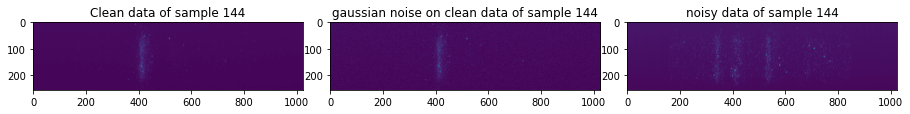

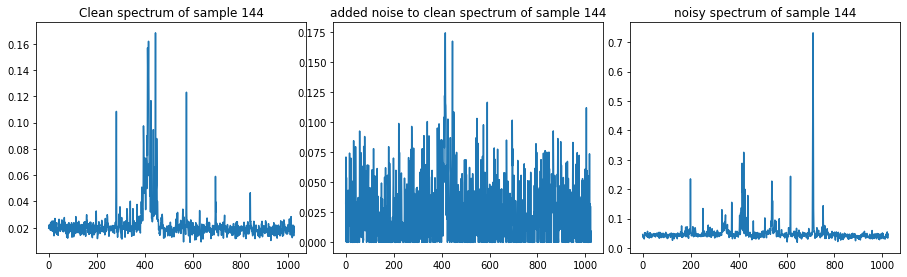

In [18]:
rand=np.random.randint(0,len(clean))
noise_factor=0.03
compare(clean,train_dataset,noise,noise_factor,rand)

# Training Loop

EPOCH 1 / 25
Partial Train loss is 0.20717592537403107
Partial Train loss is 0.18272049725055695
Partial Train loss is 0.15806999802589417
Partial Train loss is 0.1381119191646576
Partial Train loss is 0.122377410531044
Partial Train loss is 0.1085258349776268
Partial Train loss is 0.09537964314222336
Partial Train loss is 0.08504103869199753
Partial Train loss is 0.07695410400629044
Partial Train loss is 0.06752123683691025
Partial Train loss is 0.06345326453447342
Partial Train loss is 0.05776531249284744
Partial Train loss is 0.04871925711631775
Partial Train loss is 0.04318910837173462
Partial Train loss is 0.040140021592378616
Partial Train loss is 0.034901730716228485
Partial Train loss is 0.032503195106983185
Partial Train loss is 0.028594881296157837
Partial Train loss is 0.0267940666526556
Partial Train loss is 0.024233050644397736
partial validation loss is 0.03586304560303688 

 EPOCH 1/25 	 train loss 0.082 	 val loss 0.036


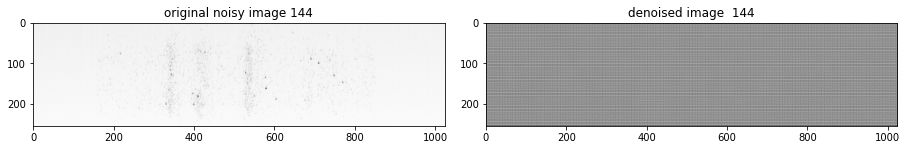

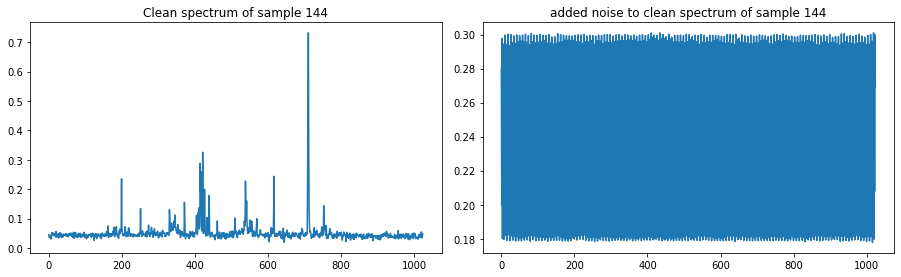

EPOCH 2 / 25
Partial Train loss is 0.021638285368680954
Partial Train loss is 0.020717015489935875
Partial Train loss is 0.021085644140839577


[W accumulate_grad.h:185] Warning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [8, 1, 3, 3], strides() = [9, 9, 3, 1]
param.sizes() = [8, 1, 3, 3], strides() = [9, 1, 3, 1] (function operator())


Partial Train loss is 0.016634946689009666
Partial Train loss is 0.015134582296013832
Partial Train loss is 0.014027233235538006
Partial Train loss is 0.012604105286300182
Partial Train loss is 0.011471129022538662
Partial Train loss is 0.010638142935931683
Partial Train loss is 0.009334126487374306
Partial Train loss is 0.008875156752765179
Partial Train loss is 0.008279143832623959
Partial Train loss is 0.007032924797385931
Partial Train loss is 0.006425820291042328
Partial Train loss is 0.006372790317982435
Partial Train loss is 0.0055657378397881985
Partial Train loss is 0.005466694477945566
Partial Train loss is 0.0049790916964411736
Partial Train loss is 0.004796368535608053
Partial Train loss is 0.004449107684195042
partial validation loss is 0.005527537316083908 

 EPOCH 2/25 	 train loss 0.011 	 val loss 0.006


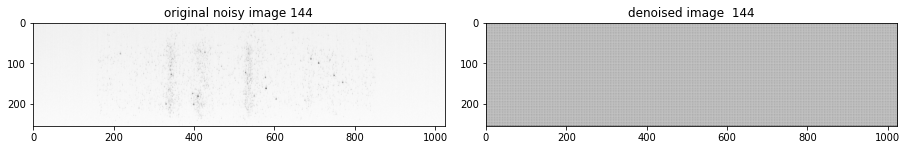

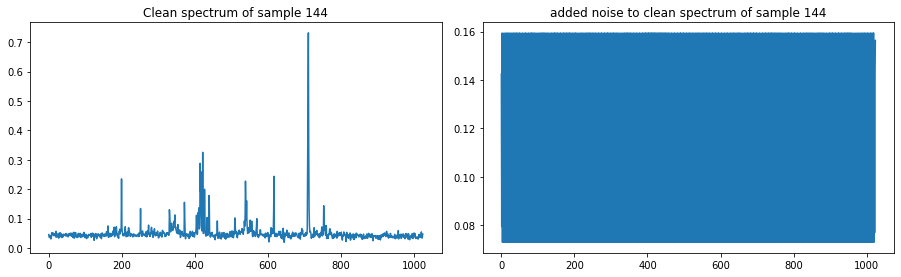

EPOCH 3 / 25
Partial Train loss is 0.003983674105256796
Partial Train loss is 0.004165198188275099
Partial Train loss is 0.003748659510165453
Partial Train loss is 0.0036744573153555393
Partial Train loss is 0.003471849951893091
Partial Train loss is 0.0032323168125003576
Partial Train loss is 0.002908332971855998
Partial Train loss is 0.002741343341767788
Partial Train loss is 0.002635375829413533
Partial Train loss is 0.002420483622699976
Partial Train loss is 0.0023474320769309998
Partial Train loss is 0.002286470029503107
Partial Train loss is 0.0020347144454717636
Partial Train loss is 0.0018247828120365739
Partial Train loss is 0.0019189969170838594
Partial Train loss is 0.0017358765471726656
Partial Train loss is 0.0017829384887591004
Partial Train loss is 0.0017497878288850188
Partial Train loss is 0.0016289096092805266
Partial Train loss is 0.0015519155422225595
partial validation loss is 0.002266285941004753 

 EPOCH 3/25 	 train loss 0.003 	 val loss 0.002


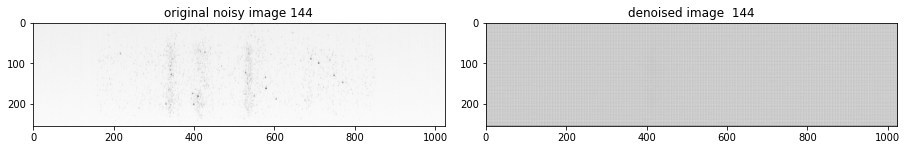

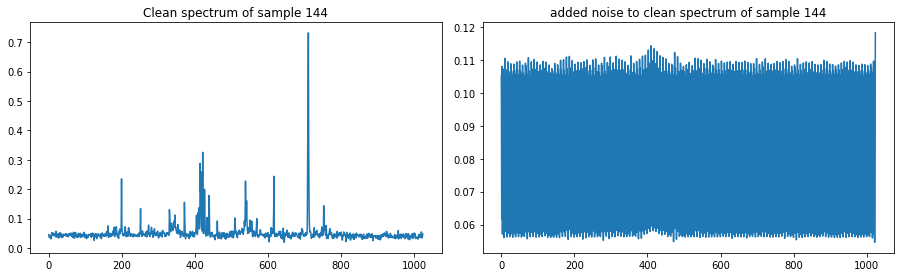

EPOCH 4 / 25
Partial Train loss is 0.0014099192339926958
Partial Train loss is 0.0014241465833038092
Partial Train loss is 0.0014558618422597647
Partial Train loss is 0.0013049778062850237
Partial Train loss is 0.0016577041242271662
Partial Train loss is 0.0015468192286789417
Partial Train loss is 0.0013582827523350716
Partial Train loss is 0.0013048643013462424
Partial Train loss is 0.001280053867958486
Partial Train loss is 0.0012604004004970193
Partial Train loss is 0.0012302505783736706
Partial Train loss is 0.001235063187777996
Partial Train loss is 0.0012002307921648026
Partial Train loss is 0.0010465625673532486
Partial Train loss is 0.001107729971408844
Partial Train loss is 0.0010645670117810369
Partial Train loss is 0.001311811967752874
Partial Train loss is 0.0011674250708892941
Partial Train loss is 0.0010166087886318564
Partial Train loss is 0.0009738197550177574
partial validation loss is 0.0017228479264304042 

 EPOCH 4/25 	 train loss 0.001 	 val loss 0.002


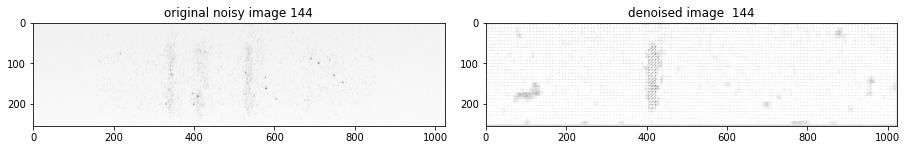

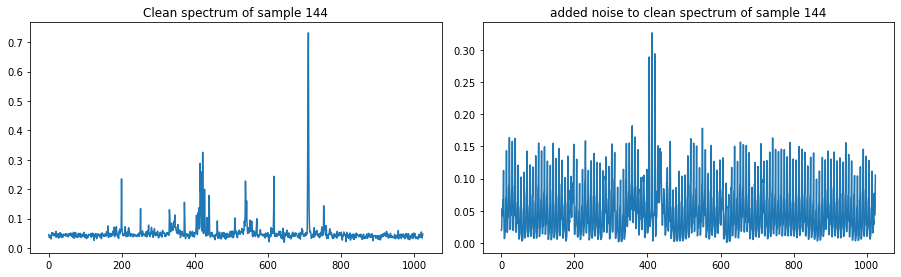

EPOCH 5 / 25
Partial Train loss is 0.0009002321748994291
Partial Train loss is 0.0009009005734696984
Partial Train loss is 0.0009987525409087539
Partial Train loss is 0.0008830549195408821
Partial Train loss is 0.000945541076362133
Partial Train loss is 0.0009244736284017563
Partial Train loss is 0.0008519415860064328
Partial Train loss is 0.0008365168469026685
Partial Train loss is 0.0008287500822916627
Partial Train loss is 0.0008606499177403748
Partial Train loss is 0.000845878035761416
Partial Train loss is 0.0008618429419584572
Partial Train loss is 0.0008788990671746433
Partial Train loss is 0.0007672117790207267
Partial Train loss is 0.0008120668935589492
Partial Train loss is 0.0008004458504728973
Partial Train loss is 0.0008132766815833747
Partial Train loss is 0.0008849365985952318
Partial Train loss is 0.0007700223359279335
Partial Train loss is 0.0007437964668497443
partial validation loss is 0.001061160466633737 

 EPOCH 5/25 	 train loss 0.001 	 val loss 0.001


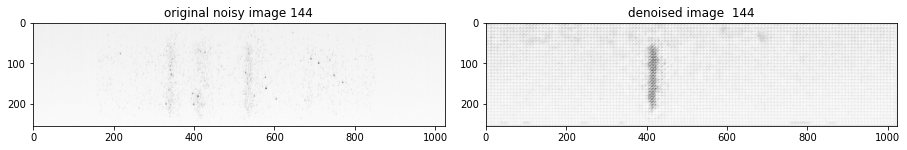

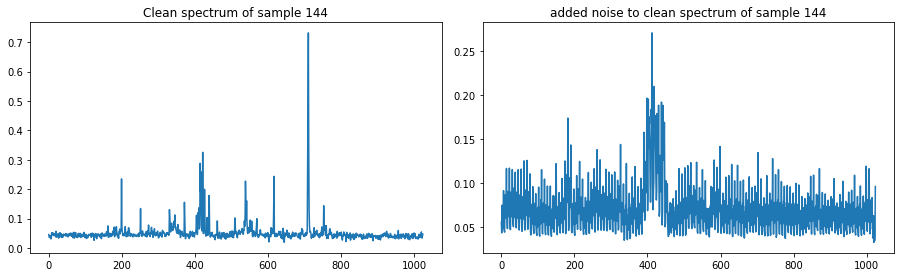

EPOCH 6 / 25
Partial Train loss is 0.0006921128369867802
Partial Train loss is 0.0006822926225140691
Partial Train loss is 0.0007901081698946655
Partial Train loss is 0.0006978449528105557
Partial Train loss is 0.000757858157157898
Partial Train loss is 0.0007461646455340087
Partial Train loss is 0.0006942686741240323
Partial Train loss is 0.000680012337397784
Partial Train loss is 0.0006731534958817065
Partial Train loss is 0.0007191451149992645
Partial Train loss is 0.0007076337933540344
Partial Train loss is 0.0007278017001226544
Partial Train loss is 0.0007540640654042363
Partial Train loss is 0.0006503865588456392
Partial Train loss is 0.0006784262950532138
Partial Train loss is 0.0006853725644759834
Partial Train loss is 0.0006825899472460151
Partial Train loss is 0.000753965403418988
Partial Train loss is 0.000666289241053164
Partial Train loss is 0.0006348612951114774
partial validation loss is 0.0007775046397000551 

 EPOCH 6/25 	 train loss 0.001 	 val loss 0.001


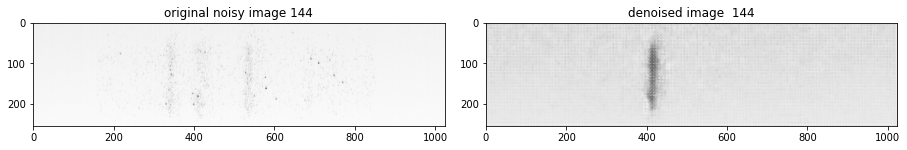

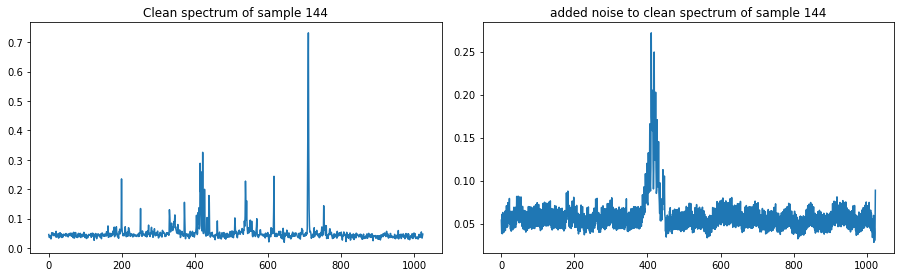

EPOCH 7 / 25
Partial Train loss is 0.0005994429811835289
Partial Train loss is 0.0005759891355410218
Partial Train loss is 0.0006881387671455741
Partial Train loss is 0.0006007555057294667
Partial Train loss is 0.000654139497783035
Partial Train loss is 0.0006494602421298623
Partial Train loss is 0.0006008359487168491
Partial Train loss is 0.0005880910903215408
Partial Train loss is 0.0005776587058790028
Partial Train loss is 0.000626571592874825
Partial Train loss is 0.0006157266325317323
Partial Train loss is 0.0006269059958867729
Partial Train loss is 0.0006773817585781217
Partial Train loss is 0.0005790652940049767
Partial Train loss is 0.0005979768466204405
Partial Train loss is 0.0006081138271838427
Partial Train loss is 0.0006005621398799121
Partial Train loss is 0.0006693318719044328
Partial Train loss is 0.0005940049304626882
Partial Train loss is 0.0005541201098822057
partial validation loss is 0.0009402314317412674 

 EPOCH 7/25 	 train loss 0.001 	 val loss 0.001


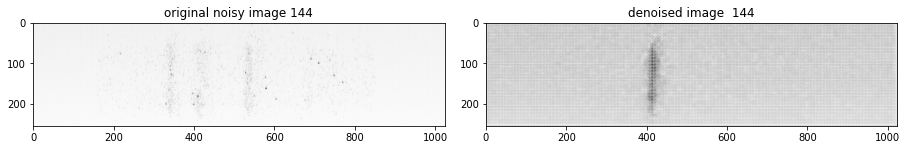

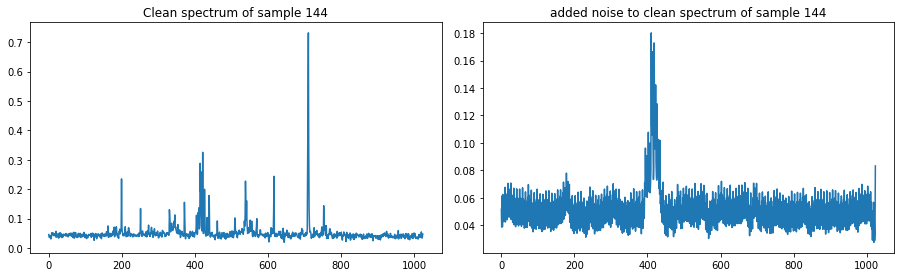

EPOCH 8 / 25
Partial Train loss is 0.0005310563719831407
Partial Train loss is 0.0005086946184746921
Partial Train loss is 0.0006203094380907714
Partial Train loss is 0.0005345137324184179
Partial Train loss is 0.0005814412725158036
Partial Train loss is 0.0005785715766251087
Partial Train loss is 0.0005348673439584672
Partial Train loss is 0.0005265406216494739
Partial Train loss is 0.0005179598811082542
Partial Train loss is 0.000559717882424593
Partial Train loss is 0.0005475531215779483
Partial Train loss is 0.0005567581974901259
Partial Train loss is 0.0006148698157630861
Partial Train loss is 0.0005260902689769864
Partial Train loss is 0.0005425739218480885
Partial Train loss is 0.0005548841436393559
Partial Train loss is 0.0005394699401222169
Partial Train loss is 0.0006109069217927754
Partial Train loss is 0.0005360209615901113
Partial Train loss is 0.000497970380820334
partial validation loss is 0.0007844074280001223 

 EPOCH 8/25 	 train loss 0.001 	 val loss 0.001


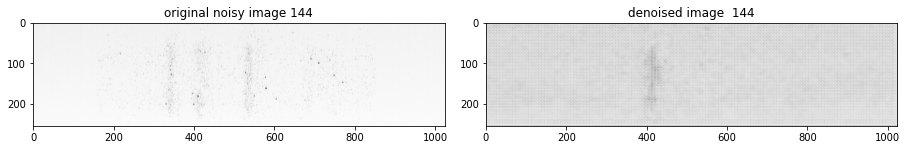

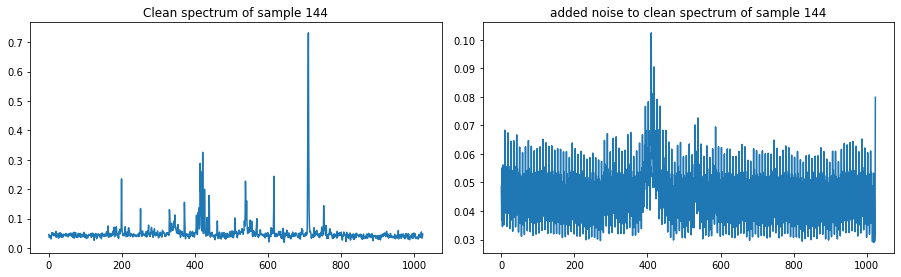

EPOCH 9 / 25
Partial Train loss is 0.00048044996219687164
Partial Train loss is 0.000456278765341267
Partial Train loss is 0.0005686568329110742
Partial Train loss is 0.0004824674688279629
Partial Train loss is 0.0005247690132819116
Partial Train loss is 0.0005176003323867917
Partial Train loss is 0.00048078896361403167
Partial Train loss is 0.0004757614806294441
Partial Train loss is 0.00047193674254231155
Partial Train loss is 0.0005093432264402509
Partial Train loss is 0.00048155972035601735
Partial Train loss is 0.0004956327611580491
Partial Train loss is 0.0005555132520385087
Partial Train loss is 0.00048510319902561605
Partial Train loss is 0.0004916029283776879
Partial Train loss is 0.0005062326672486961
Partial Train loss is 0.000484222371596843
Partial Train loss is 0.000563280947972089
Partial Train loss is 0.0004880062770098448
Partial Train loss is 0.00044957525096833706
partial validation loss is 0.0007582735852338374 

 EPOCH 9/25 	 train loss 0.000 	 val loss 0.001


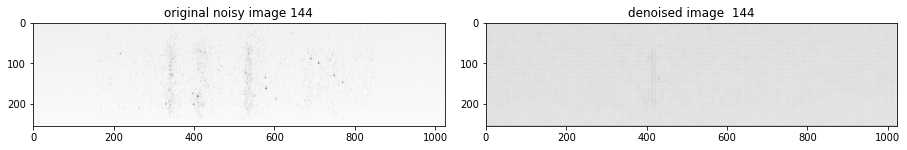

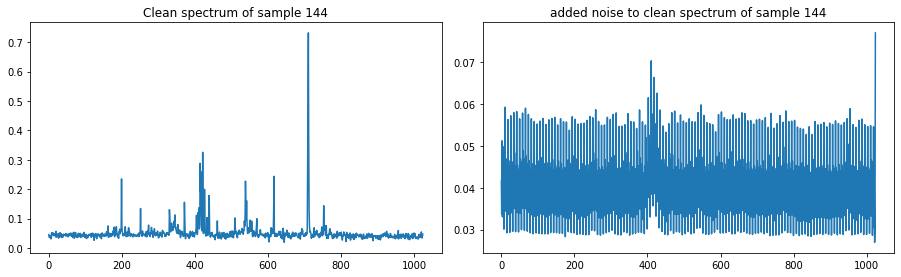

EPOCH 10 / 25
Partial Train loss is 0.00044017573236487806
Partial Train loss is 0.0004166959261056036
Partial Train loss is 0.0005231001996435225
Partial Train loss is 0.0004429573309607804
Partial Train loss is 0.00047885789535939693
Partial Train loss is 0.00046773377107456326
Partial Train loss is 0.00043512621778063476
Partial Train loss is 0.0004296376428101212
Partial Train loss is 0.00042868367745541036
Partial Train loss is 0.00046386438771151006
Partial Train loss is 0.0004306997579988092
Partial Train loss is 0.00044173491187393665
Partial Train loss is 0.0005129288765601814
Partial Train loss is 0.000449581362772733
Partial Train loss is 0.0004505537508521229
Partial Train loss is 0.0004709959030151367
Partial Train loss is 0.0004459598276298493
Partial Train loss is 0.0005253364215604961
Partial Train loss is 0.00046063773334026337
Partial Train loss is 0.00040698848897591233
partial validation loss is 0.000724640442058444 

 EPOCH 10/25 	 train loss 0.000 	 val loss 0.001

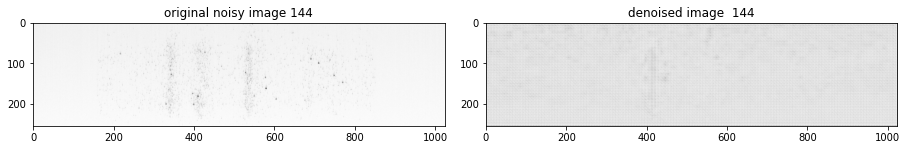

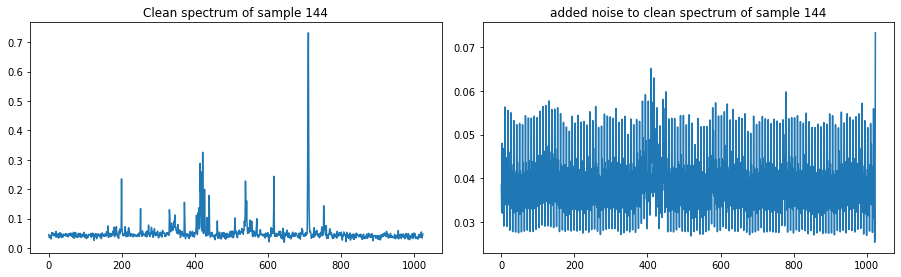

EPOCH 11 / 25
Partial Train loss is 0.0004068307753186673
Partial Train loss is 0.0003861825098283589
Partial Train loss is 0.00048606988275423646
Partial Train loss is 0.0004083616368006915
Partial Train loss is 0.0004400259058456868
Partial Train loss is 0.00043357309186831117
Partial Train loss is 0.0004008566029369831
Partial Train loss is 0.00039422084228135645
Partial Train loss is 0.0003943291958421469
Partial Train loss is 0.00043213824392296374
Partial Train loss is 0.0003934876585844904
Partial Train loss is 0.0004021331260446459
Partial Train loss is 0.0004786142671946436
Partial Train loss is 0.0004212520143482834
Partial Train loss is 0.0004052994481753558
Partial Train loss is 0.00044242836884222925
Partial Train loss is 0.0004162738041486591
Partial Train loss is 0.0004909224226139486
Partial Train loss is 0.00042002933332696557
Partial Train loss is 0.0003761439584195614
partial validation loss is 0.0006631644209846854 

 EPOCH 11/25 	 train loss 0.000 	 val loss 0.001


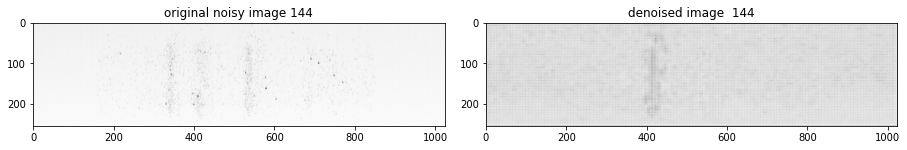

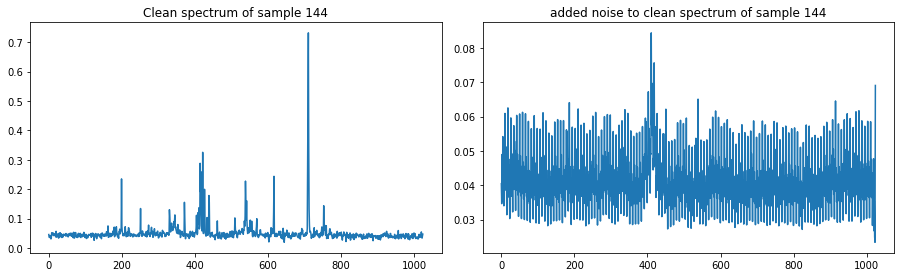

EPOCH 12 / 25
Partial Train loss is 0.00037486161454580724
Partial Train loss is 0.0003609247214626521
Partial Train loss is 0.00045493579818867147
Partial Train loss is 0.0003780946717597544
Partial Train loss is 0.0004076421319041401
Partial Train loss is 0.0003995075821876526
Partial Train loss is 0.0003772530471906066
Partial Train loss is 0.0003649541176855564
Partial Train loss is 0.0003635897592175752
Partial Train loss is 0.0003981690388172865
Partial Train loss is 0.000364319741493091
Partial Train loss is 0.00037075267755426466
Partial Train loss is 0.00044990397873334587
Partial Train loss is 0.00038244514144025743
Partial Train loss is 0.00037857136339880526
Partial Train loss is 0.00040496952715329826
Partial Train loss is 0.0003784184518735856
Partial Train loss is 0.0004603847919497639
Partial Train loss is 0.00039527678745798767
Partial Train loss is 0.0003447927301749587
partial validation loss is 0.0006310970056802034 

 EPOCH 12/25 	 train loss 0.000 	 val loss 0.001

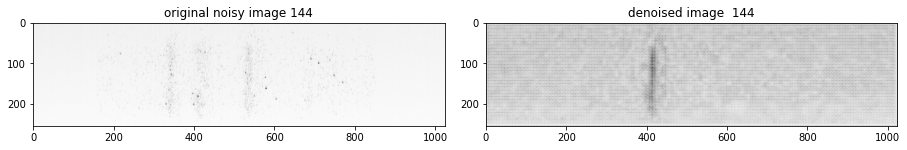

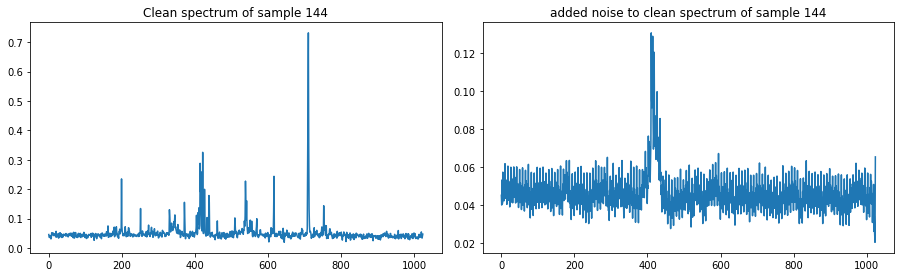

EPOCH 13 / 25
Partial Train loss is 0.0003506493812892586
Partial Train loss is 0.00033698827610351145
Partial Train loss is 0.0004238279943820089
Partial Train loss is 0.0003519379533827305
Partial Train loss is 0.00038254368701018393
Partial Train loss is 0.0003747533482965082
Partial Train loss is 0.0003515124262776226
Partial Train loss is 0.00034022386535070837
Partial Train loss is 0.00034135053283534944
Partial Train loss is 0.00037553583388216794
Partial Train loss is 0.0003375191008672118
Partial Train loss is 0.0003430589276831597
Partial Train loss is 0.00042233141721226275
Partial Train loss is 0.00036277371691539884
Partial Train loss is 0.0003530802787281573
Partial Train loss is 0.0003848884953185916
Partial Train loss is 0.00035607939935289323
Partial Train loss is 0.0004393249691929668
Partial Train loss is 0.0003665378026198596
Partial Train loss is 0.00032839112100191414
partial validation loss is 0.0004434371367096901 

 EPOCH 13/25 	 train loss 0.000 	 val loss 0.0

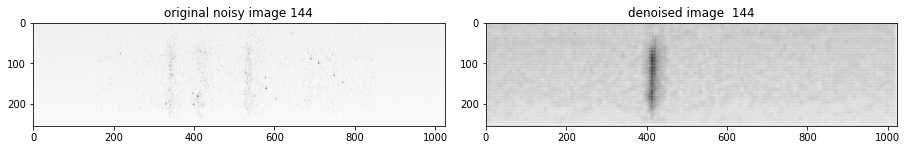

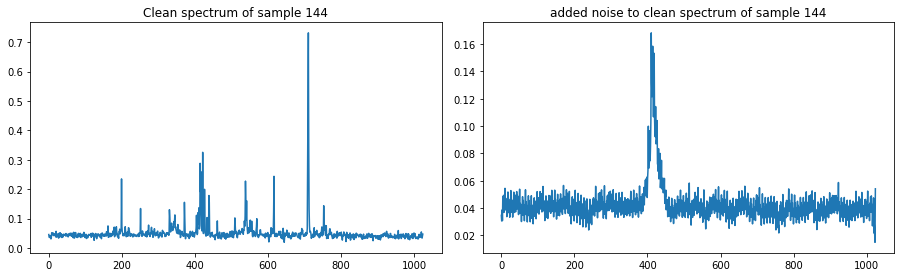

EPOCH 14 / 25
Partial Train loss is 0.0003306209109723568
Partial Train loss is 0.0003140957560390234
Partial Train loss is 0.00040334119694307446
Partial Train loss is 0.0003331166517455131
Partial Train loss is 0.0003621139912866056
Partial Train loss is 0.00035257948911748827
Partial Train loss is 0.00033198954770341516
Partial Train loss is 0.0003214143798686564
Partial Train loss is 0.00032275900593958795
Partial Train loss is 0.0003562986967153847
Partial Train loss is 0.00031918982858769596
Partial Train loss is 0.0003222945670131594
Partial Train loss is 0.00040187753620557487
Partial Train loss is 0.0003438772400841117
Partial Train loss is 0.00033600194728933275
Partial Train loss is 0.0003628700505942106
Partial Train loss is 0.00033685495145618916
Partial Train loss is 0.00042218869202770293
Partial Train loss is 0.00035100357490591705
Partial Train loss is 0.000312757765641436
partial validation loss is 0.0003986875817645341 

 EPOCH 14/25 	 train loss 0.000 	 val loss 0.0

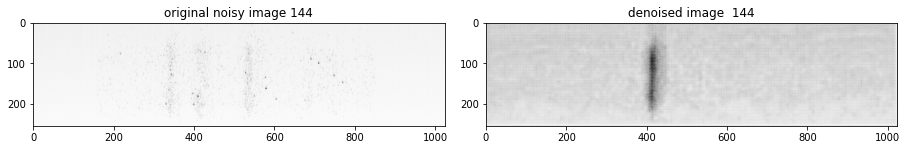

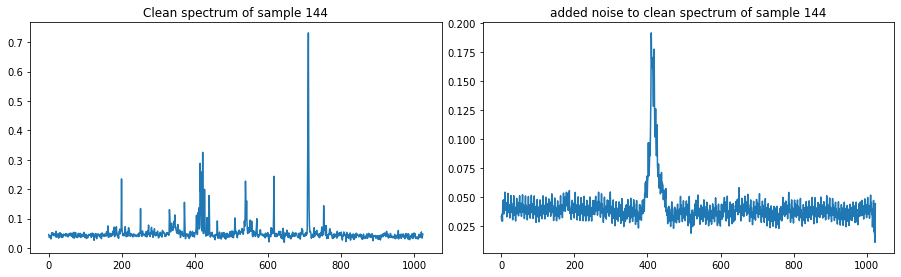

EPOCH 15 / 25
Partial Train loss is 0.00031684685382060707
Partial Train loss is 0.0002977756375912577
Partial Train loss is 0.0003844276652671397
Partial Train loss is 0.00031643229885958135
Partial Train loss is 0.0003446910995990038
Partial Train loss is 0.0003371555940248072
Partial Train loss is 0.000316138903144747
Partial Train loss is 0.00030711040017195046
Partial Train loss is 0.0003071142127737403
Partial Train loss is 0.0003390423662494868
Partial Train loss is 0.00030508736381307244
Partial Train loss is 0.0003057461290154606
Partial Train loss is 0.00038552359910681844
Partial Train loss is 0.0003239088982809335
Partial Train loss is 0.00032300068414770067
Partial Train loss is 0.0003511988325044513
Partial Train loss is 0.00032318904413841665
Partial Train loss is 0.0004057626356370747
Partial Train loss is 0.00034204768599011004
Partial Train loss is 0.0002959894191008061
partial validation loss is 0.00036954032839275897 

 EPOCH 15/25 	 train loss 0.000 	 val loss 0.00

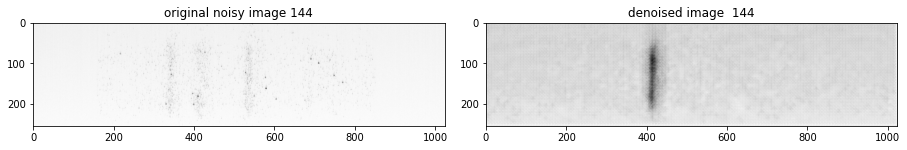

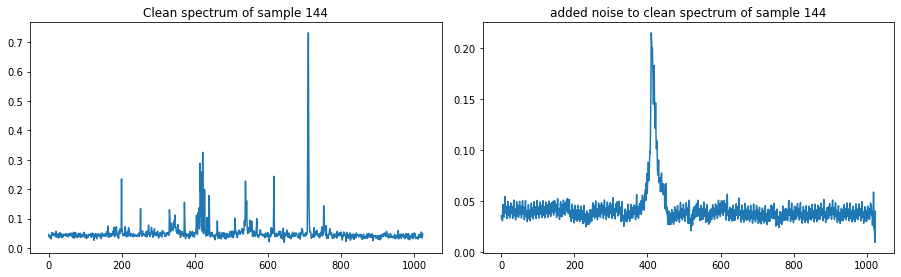

EPOCH 16 / 25
Partial Train loss is 0.00031012584804557264
Partial Train loss is 0.00028641519020311534
Partial Train loss is 0.0003714483755175024
Partial Train loss is 0.00030536504345946014
Partial Train loss is 0.00033359063672833145
Partial Train loss is 0.0003260618541389704
Partial Train loss is 0.0003009296488016844
Partial Train loss is 0.0002944122243206948
Partial Train loss is 0.0002978126285597682
Partial Train loss is 0.00032664844184182584
Partial Train loss is 0.00029557564994320273
Partial Train loss is 0.00029350497061386704
Partial Train loss is 0.00037740246625617146
Partial Train loss is 0.00031151724397204816
Partial Train loss is 0.00031432067044079304
Partial Train loss is 0.00032860206556506455
Partial Train loss is 0.00031085553928278387
Partial Train loss is 0.0003950756217818707
Partial Train loss is 0.0003196899779140949
Partial Train loss is 0.0002831440942827612
partial validation loss is 0.00037092610727995634 

 EPOCH 16/25 	 train loss 0.000 	 val loss

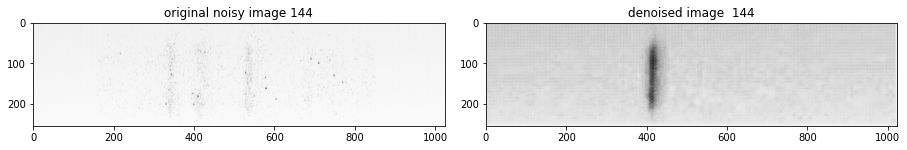

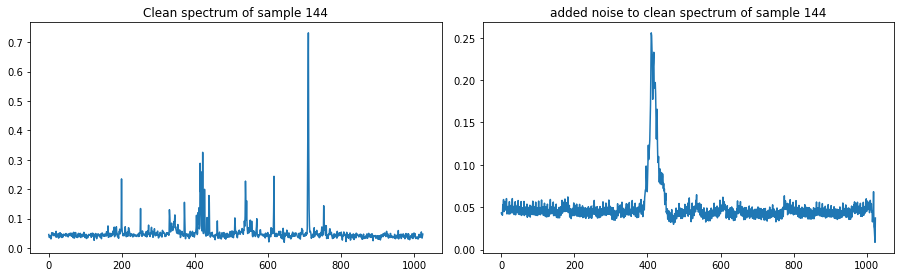

EPOCH 17 / 25
Partial Train loss is 0.00028662572731263936
Partial Train loss is 0.0002703528443817049
Partial Train loss is 0.00035694570397026837
Partial Train loss is 0.00029046303825452924
Partial Train loss is 0.0003183758817613125
Partial Train loss is 0.00031181363738141954
Partial Train loss is 0.0002943010476883501
Partial Train loss is 0.0002846618299372494
Partial Train loss is 0.0002851123281288892
Partial Train loss is 0.00031461805338039994
Partial Train loss is 0.0002820345980580896
Partial Train loss is 0.00028472402482293546
Partial Train loss is 0.00036167711368761957
Partial Train loss is 0.00029980906401760876
Partial Train loss is 0.0003031632804777473
Partial Train loss is 0.0003175917954649776
Partial Train loss is 0.0002990901411976665
Partial Train loss is 0.000382633093977347
Partial Train loss is 0.000310137722408399
Partial Train loss is 0.0002721527707763016
partial validation loss is 0.00035055377520620823 

 EPOCH 17/25 	 train loss 0.000 	 val loss 0.000

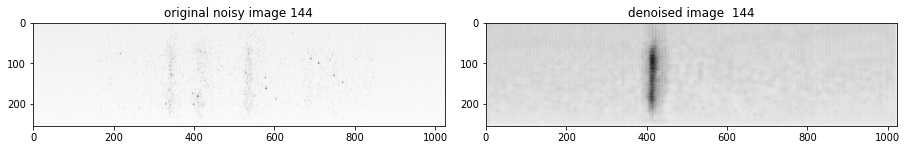

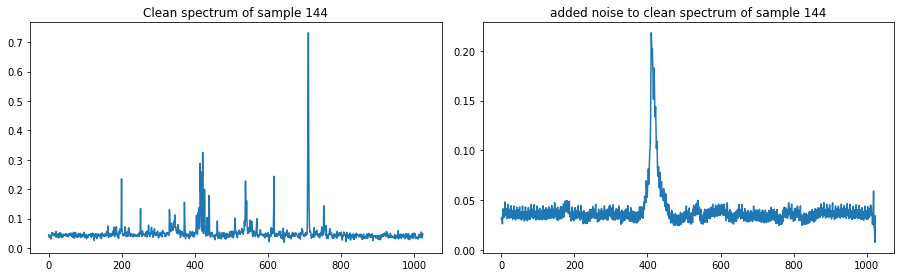

EPOCH 18 / 25
Partial Train loss is 0.00028378848219290376
Partial Train loss is 0.0002618810685817152
Partial Train loss is 0.00034588243579491973
Partial Train loss is 0.00028302305145189166
Partial Train loss is 0.000306879315758124
Partial Train loss is 0.0003004052850883454
Partial Train loss is 0.0002785779070109129
Partial Train loss is 0.0002727731189224869
Partial Train loss is 0.00027828148449771106
Partial Train loss is 0.0003079230373259634
Partial Train loss is 0.0002718692412599921
Partial Train loss is 0.00027426317683421075
Partial Train loss is 0.0003530121757648885
Partial Train loss is 0.0002918163954745978
Partial Train loss is 0.00029567512683570385
Partial Train loss is 0.0003101449110545218
Partial Train loss is 0.0002909364702645689
Partial Train loss is 0.0003762169217225164
Partial Train loss is 0.00030743214301764965
Partial Train loss is 0.0002687886299099773
partial validation loss is 0.000340642174705863 

 EPOCH 18/25 	 train loss 0.000 	 val loss 0.000


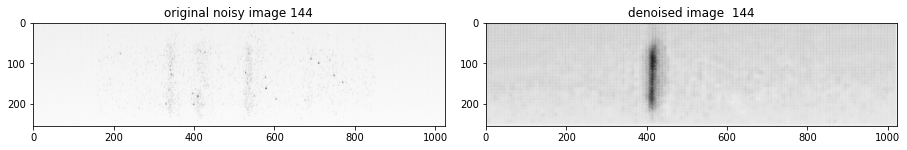

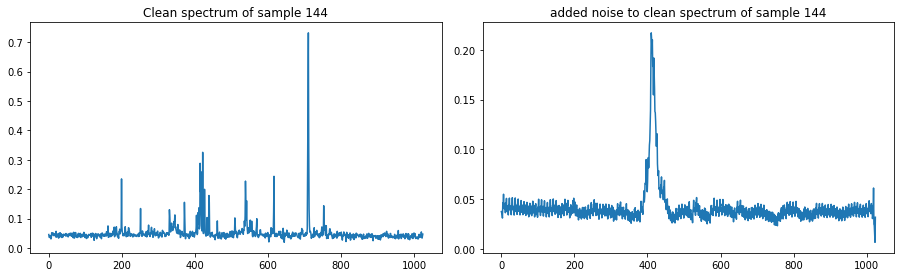

EPOCH 19 / 25
Partial Train loss is 0.00028069884865544736
Partial Train loss is 0.0002590425137896091
Partial Train loss is 0.00034165289252996445
Partial Train loss is 0.0002798037603497505
Partial Train loss is 0.00030356604838743806
Partial Train loss is 0.0002975471143145114
Partial Train loss is 0.0002778596244752407
Partial Train loss is 0.0002692599955480546
Partial Train loss is 0.000275547819910571
Partial Train loss is 0.00030120561132207513
Partial Train loss is 0.0002667810767889023
Partial Train loss is 0.00027082435553893447
Partial Train loss is 0.0003424694878049195
Partial Train loss is 0.0002848141302820295
Partial Train loss is 0.0002851757453754544
Partial Train loss is 0.0002968182088807225
Partial Train loss is 0.00028238349477760494
Partial Train loss is 0.0003680524823721498
Partial Train loss is 0.0002889060415327549
Partial Train loss is 0.0002569381322246045
partial validation loss is 0.00030822205008007586 

 EPOCH 19/25 	 train loss 0.000 	 val loss 0.000


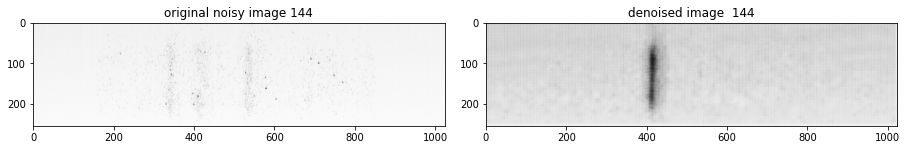

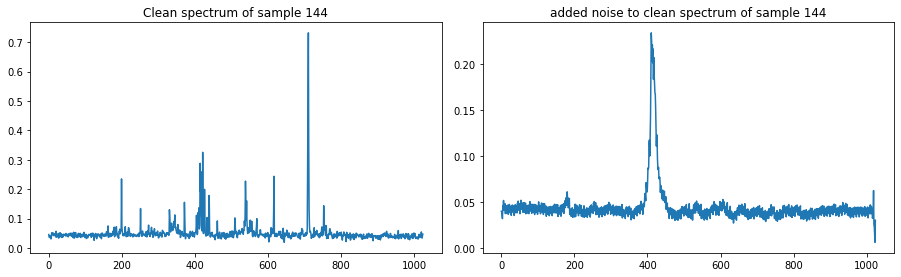

EPOCH 20 / 25
Partial Train loss is 0.0002645233180373907
Partial Train loss is 0.00024772784672677517
Partial Train loss is 0.00033140680170618
Partial Train loss is 0.0002690192486625165
Partial Train loss is 0.00029331748373806477
Partial Train loss is 0.00028689781902357936
Partial Train loss is 0.0002693351998459548
Partial Train loss is 0.0002615298726595938
Partial Train loss is 0.00026955254725180566
Partial Train loss is 0.00029902803362347186
Partial Train loss is 0.00025958867627196014
Partial Train loss is 0.00026289536617696285
Partial Train loss is 0.00033836919465102255
Partial Train loss is 0.0002805891272146255
Partial Train loss is 0.00027978644357062876
Partial Train loss is 0.00029592469218187034
Partial Train loss is 0.00028100606868974864
Partial Train loss is 0.00036151069798506796
Partial Train loss is 0.0002913777716457844
Partial Train loss is 0.0002576902334112674
partial validation loss is 0.0003133404243271798 

 EPOCH 20/25 	 train loss 0.000 	 val loss 0.

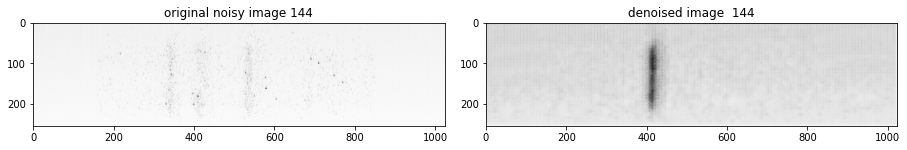

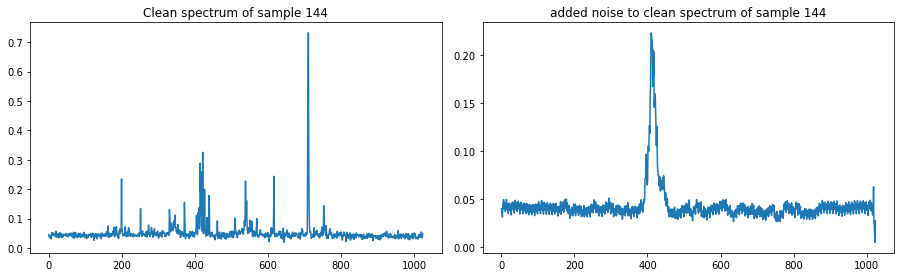

EPOCH 21 / 25
Partial Train loss is 0.0002668045926839113
Partial Train loss is 0.0002462389529682696
Partial Train loss is 0.00032852886943146586
Partial Train loss is 0.000268537929514423
Partial Train loss is 0.00028969274717383087
Partial Train loss is 0.00028435044805519283
Partial Train loss is 0.0002653864794410765
Partial Train loss is 0.00025914638536050916
Partial Train loss is 0.00026448589051142335
Partial Train loss is 0.00029281285242177546
Partial Train loss is 0.00025437260046601295
Partial Train loss is 0.00025804885081015527
Partial Train loss is 0.00032937340438365936
Partial Train loss is 0.0002766437828540802
Partial Train loss is 0.0002762179065030068
Partial Train loss is 0.0002894037461373955
Partial Train loss is 0.00027323048561811447
Partial Train loss is 0.0003583249927032739
Partial Train loss is 0.00028332191868685186
Partial Train loss is 0.0002507393655832857
partial validation loss is 0.0003169967094436288 

 EPOCH 21/25 	 train loss 0.000 	 val loss 0.

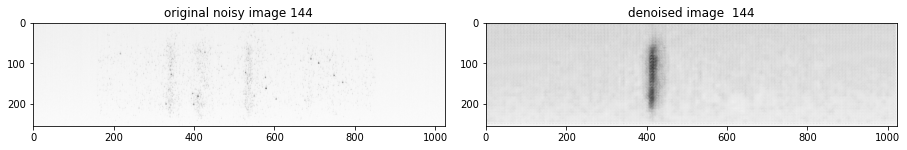

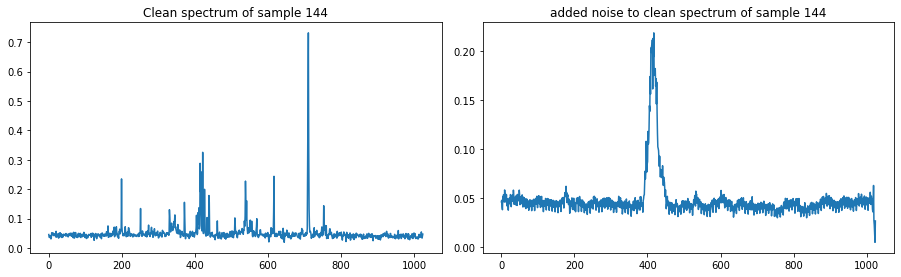

EPOCH 22 / 25
Partial Train loss is 0.0002575455291662365
Partial Train loss is 0.0002398353535681963
Partial Train loss is 0.0003255369374528527
Partial Train loss is 0.00026056997012346983
Partial Train loss is 0.0002832849568221718
Partial Train loss is 0.0002795604523271322
Partial Train loss is 0.00026247408823110163
Partial Train loss is 0.00025636464124545455
Partial Train loss is 0.00025918055325746536
Partial Train loss is 0.0002916698285844177
Partial Train loss is 0.0002498025423847139
Partial Train loss is 0.0002552388177718967
Partial Train loss is 0.00032547683804295957
Partial Train loss is 0.0002728286199271679
Partial Train loss is 0.0002700870099943131
Partial Train loss is 0.0002849350275937468
Partial Train loss is 0.00026984469150193036
Partial Train loss is 0.00035582573036663234
Partial Train loss is 0.00027360834064893425
Partial Train loss is 0.00024564817431382835
partial validation loss is 0.000303708016872406 

 EPOCH 22/25 	 train loss 0.000 	 val loss 0.00

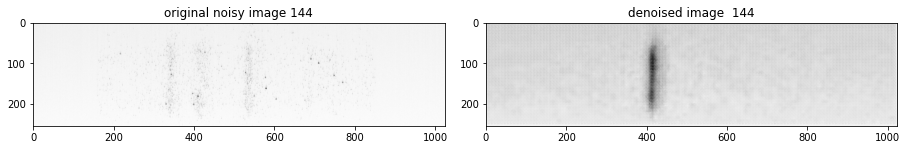

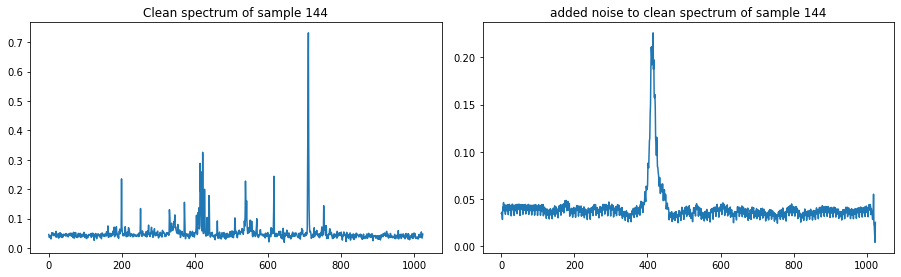

EPOCH 23 / 25
Partial Train loss is 0.00025047967210412025
Partial Train loss is 0.0002350294525967911
Partial Train loss is 0.0003192550502717495
Partial Train loss is 0.0002564817841630429
Partial Train loss is 0.00028151157312095165
Partial Train loss is 0.0002756395551841706
Partial Train loss is 0.0002599970903247595
Partial Train loss is 0.00025374777032993734
Partial Train loss is 0.00025603905669413507
Partial Train loss is 0.00028610421577468514
Partial Train loss is 0.00024778503575362265
Partial Train loss is 0.0002513699291739613
Partial Train loss is 0.00032376786111854017
Partial Train loss is 0.00027023378061130643
Partial Train loss is 0.00026799755869433284
Partial Train loss is 0.0002840611559804529
Partial Train loss is 0.00026846022228710353
Partial Train loss is 0.0003526913351379335
Partial Train loss is 0.00027302830130793154
Partial Train loss is 0.0002428676962153986
partial validation loss is 0.0003050037194043398 

 EPOCH 23/25 	 train loss 0.000 	 val loss 0

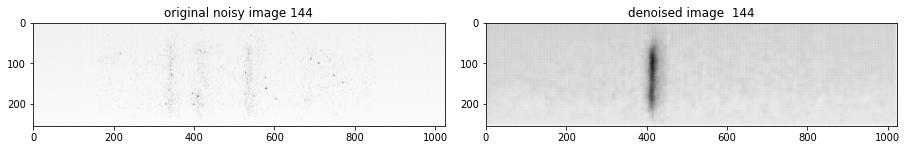

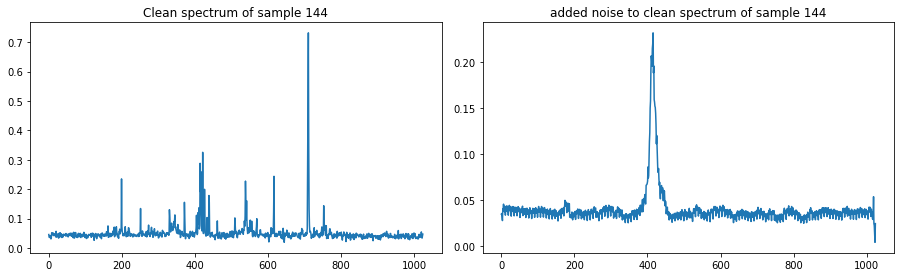

EPOCH 24 / 25
Partial Train loss is 0.0002497976820450276
Partial Train loss is 0.00023313541896641254
Partial Train loss is 0.00031700084218755364
Partial Train loss is 0.0002546247560530901
Partial Train loss is 0.00027776198112405837
Partial Train loss is 0.000273521727649495
Partial Train loss is 0.00025610608281567693
Partial Train loss is 0.00025049614487215877
Partial Train loss is 0.0002516767999622971
Partial Train loss is 0.0002812785969581455
Partial Train loss is 0.0002443017438054085
Partial Train loss is 0.00024899025447666645
Partial Train loss is 0.0003232405870221555
Partial Train loss is 0.00026855451869778335
Partial Train loss is 0.00026774979778565466
Partial Train loss is 0.00027998830773867667
Partial Train loss is 0.0002657895383890718
Partial Train loss is 0.00035199278499931097
Partial Train loss is 0.00026686207274906337
Partial Train loss is 0.00023916736245155334
partial validation loss is 0.00034313806099817157 

 EPOCH 24/25 	 train loss 0.000 	 val loss 

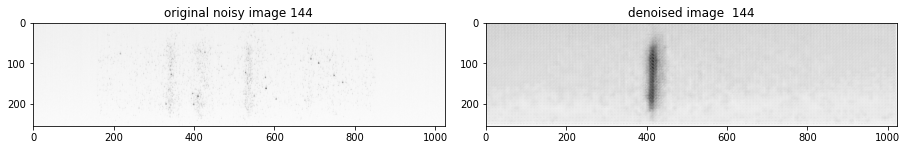

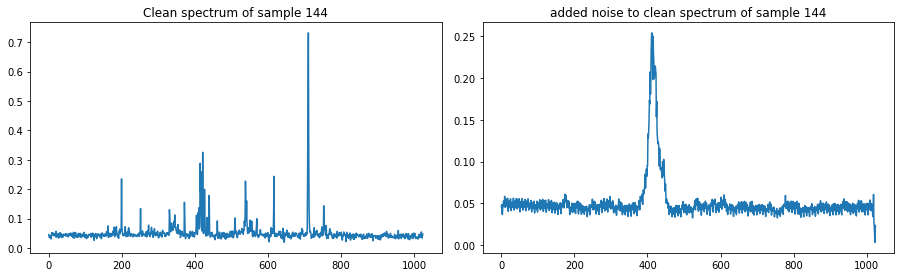

EPOCH 25 / 25
Partial Train loss is 0.00024382409173995256
Partial Train loss is 0.00023048315779305995
Partial Train loss is 0.00030988603248260915
Partial Train loss is 0.00025150339934043586
Partial Train loss is 0.0002757426700554788
Partial Train loss is 0.0002685080689843744
Partial Train loss is 0.0002532771322876215
Partial Train loss is 0.00024748724536038935
Partial Train loss is 0.0002516222302801907
Partial Train loss is 0.0002771760628093034
Partial Train loss is 0.00024210968695115298
Partial Train loss is 0.00024707530974410474
Partial Train loss is 0.00031880539609119296
Partial Train loss is 0.00026419656933285296
Partial Train loss is 0.0002661672479007393
Partial Train loss is 0.00027853623032569885
Partial Train loss is 0.00026297225849702954
Partial Train loss is 0.00034883941407315433
Partial Train loss is 0.0002683651982806623
Partial Train loss is 0.00023830328427720815
partial validation loss is 0.0002787226694636047 

 EPOCH 25/25 	 train loss 0.000 	 val loss

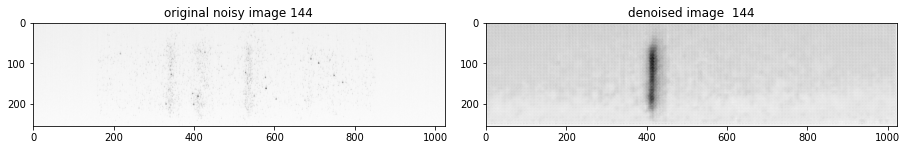

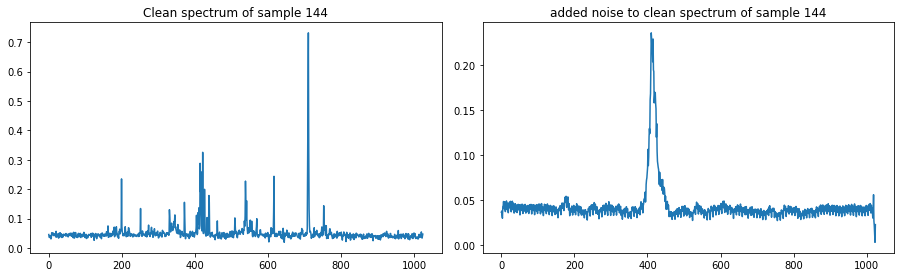

In [19]:
### Training cycle
num_epochs = 25
history_da={'train_loss':[],'val_loss':[]}
train_losss=[]
for epoch in range(num_epochs):
    print('EPOCH {} / {}'.format(epoch + 1, num_epochs))
    ### Training (use the training function)
    train_loss=train_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_loader, 
        loss_fn=loss_fn, 
        optimizer=optim,
        noise_fac=noise_factor)
    ### Validation  (use the testing function)
    val_loss = vali_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=valid_loader, 
        loss_fn=loss_fn,
        noise_fac=noise_factor)
    # Print Validationloss
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    train_losss.append(train_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    denoised=plotting(test_dataset,encoder,decoder,rand)
    
    
    

# Final Analysis


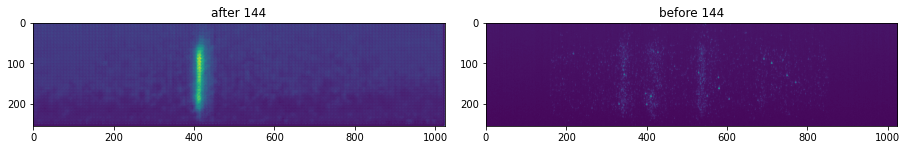

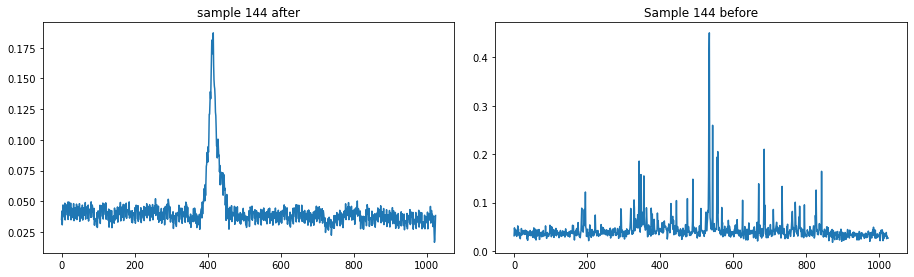

In [25]:
final=denoised#.cpu().permute(0,2,3,1).squeeze().numpy()
for i in range(1):
    plt.subplot(1,2,1)
    plt.imshow(final[rand+i])
    plt.title('after {}'.format(rand+i))
    plt.subplot(1,2,2)
    plt.imshow(noise[rand+i])
    plt.title('before {}'.format(rand+i))
    plt.subplots_adjust(left=1,
                    bottom=0.1, 
                    right=3, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.2) 
    plt.show()
    
    
    
x=np.linspace(0,1024,1024)
for i in range(1):
    plt.subplot(1,2,1)
    plt.plot(x,denoised[rand+i][150])
    plt.title('sample {} after'.format(rand+i))
    plt.subplot(1,2,2)
    plt.plot(x,noise[rand+i][150])
    plt.title('Sample {} before'.format(rand+i))
    plt.subplots_adjust(left=1,
                    bottom=0.1, 
                    right=3, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.2) 
    plt.show()

/tmp/ipykernel_766/1783775148.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Mnd1= np.asarray(Mnd)


Relative error at center of capillary: 0.040249323023576346


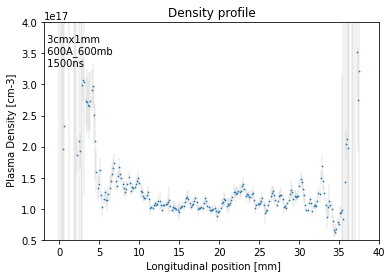

In [26]:
post_anal, dc, tk= main(denoised)
beaut(post_anal, dc, tk)